# K-Means Clustering

Importing all necessary Libraries

In [1]:
import h5py    
import numpy as np 
import matplotlib.pyplot as plt
from pyjet import cluster,DTYPE_PTEPM
import pandas as pd
from matplotlib.pyplot import cm
from matplotlib.colors import LinearSegmentedColormap
import os
import sklearn
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
import sklearn.metrics as sm
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler

# Reading .h5 file

In [2]:
def readHadrons(mytype, filename = 'hadron.h5'):
    savename = H5output + mytype + '_' + filename
    if not os.path.exists(savename):
        print('\x1b[31m[Warn.]\x1b[0m', savename, '\x1b[31mNOT\x1b[0m', 'found')
        return
    keys = []
    with h5py.File(savename, 'r') as f:
        keys = list(f)
    for key in keys:
        event = pd.read_hdf(savename, key=key)
        events_combined = event.T
        np.shape(events_combined)
        yield events_combined

# Elbow curve and K-Means clustering

In order to use K-Means clustering algorithm, we need to first feed in the no. of clusters we want to form from all the hadron entries in an event. So, in order to know the optimal number of clusters which can be formed, we will use the concept of sum of squared distances and check it for let suppose from 1 cluster to 10 clusters. For that we will first compute the Elbow curve. So our aim is to find a point (value of K) after which there will be a very less change in sum of the squared distance from the cluster centroid.

Once we get the optimal values for no. of clusters, we can easily run KMeans fit to label our dataset into these clusters. If you see, I have plotted the cluster formed from 1 cluster to 5 clusters in order to see how it works. 

An important thing to note, here I have used Phi & Eta as two features as inputs for my KMeans algorithm. We can also give Pt as the third feature or maybe give any other combination of two features. I have tried all these possible ways, it gives good result but if you plot it on Phi-Eta plane, it does not make any sense. You can also play around with it and try to optimize our Elbow curve.

And we can also give some weights to each hadron entry in an event. It can also help us to optimize our Elbow curve.

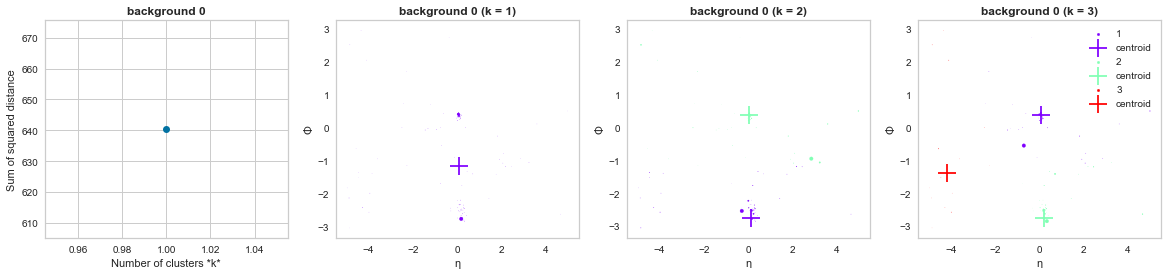

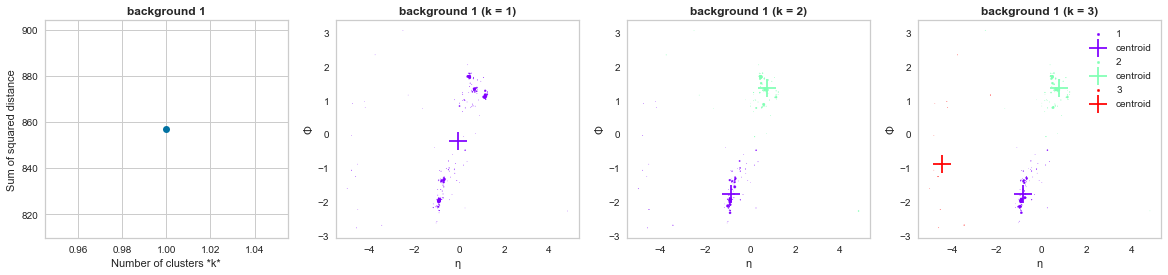

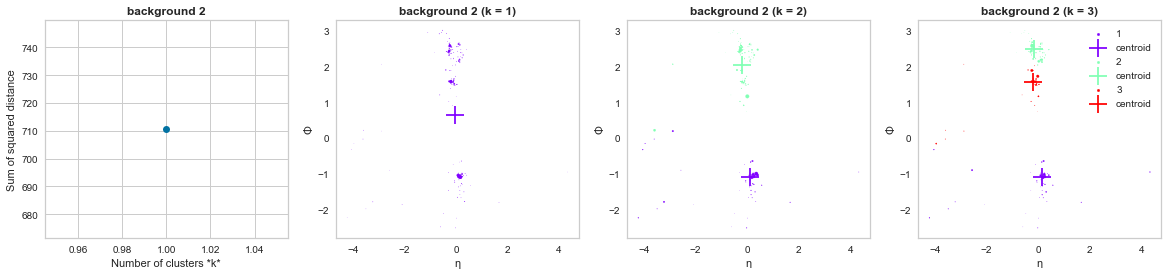

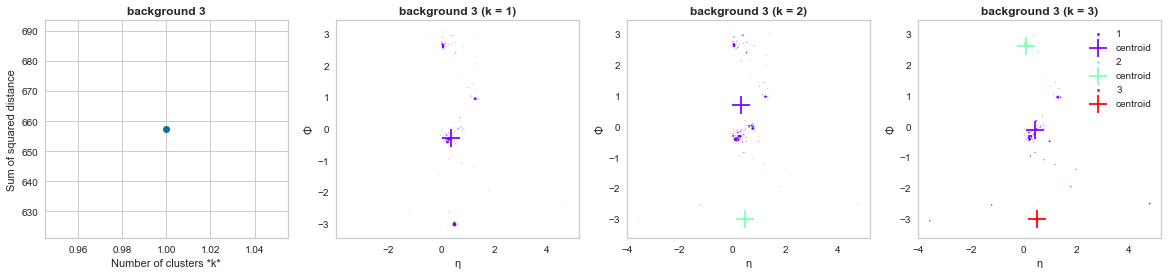

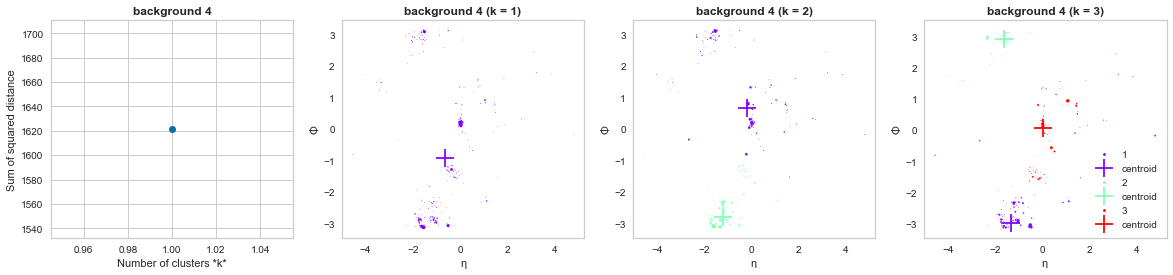

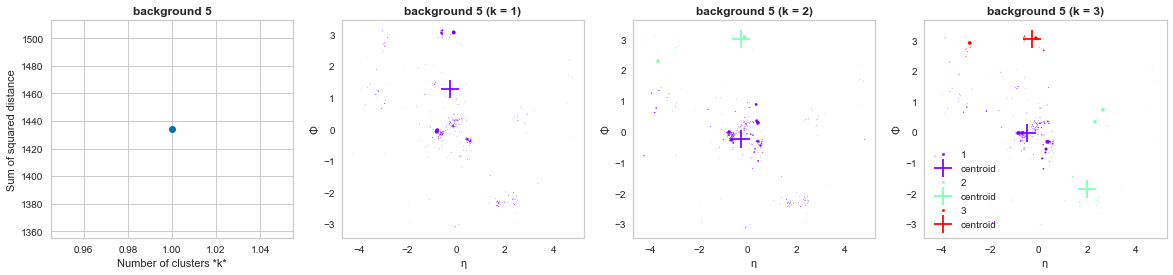

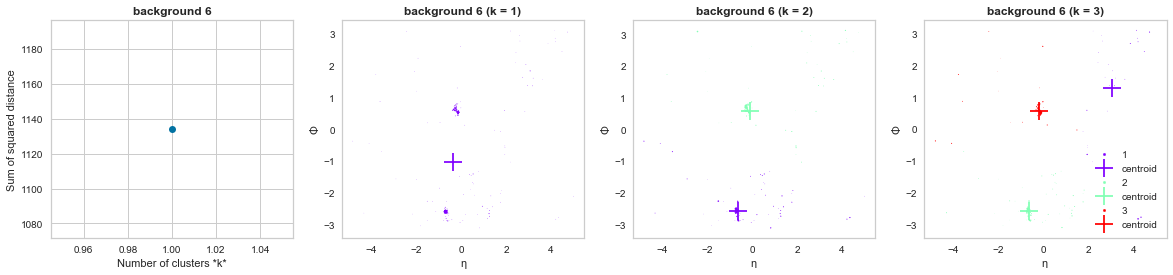

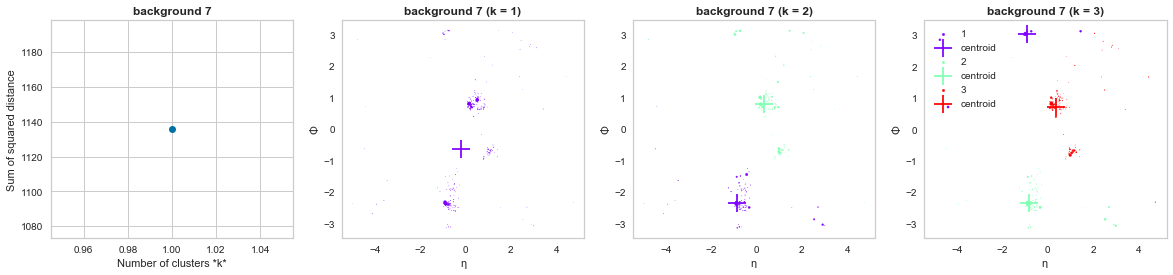

In [37]:
H5output = '../h5files/'
mytype = 'background'
for ievt, event in enumerate(readHadrons(mytype)):
    pT = np.asarray(event.loc['pT'])
    eta = np.asarray(event.loc['eta'])
    phi = np.asarray(event.loc['phi'])
    feature = np.asarray(event)
    
    x = eta
    y = phi
    w = pT
    feature = np.vstack((x, y)).T
    X_std = feature
#     X_std = StandardScaler().fit_transform(feature)
    
    # Get Elbow
    sse = []
    for k in range(1, 2):
        km = KMeans(n_clusters=k)
        km.fit(X_std)
        sse.append(km.inertia_)

    max_k = 3
    
    # Plot sse against k
    fig = plt.figure(figsize=(20, max_k+1))
    ax = fig.add_subplot(1, max_k+1, 1)
    plt.plot(range(1, len(sse)+1), sse, '-o')
    plt.xlabel(r'Number of clusters *k*')
    plt.ylabel('Sum of squared distance')
    plt.title(mytype+' '+str(ievt), fontweight='bold')
    
    def plotScatter(fig, max_k, X_std, w):


#         cmap2 = LinearSegmentedColormap.from_list('cmap', colors, len(colors)+1)
        for j in range(1,max_k+1):
#         for j, c in zip(range(1,max_k+1), colors):
            colors = cm.rainbow(np.linspace(0, 1, max_k))
            cmap = LinearSegmentedColormap.from_list('cmap', colors, len(colors)+1)
            km = KMeans(n_clusters=j, max_iter=100)
            km.fit(X_std, sample_weight = w)
            centroids = km.cluster_centers_

            ax = fig.add_subplot(1, max_k+1, j+1)
            ax.grid(False)
            
            for i, c in zip(range(j), colors[:j]):
                plt.xlabel('\u03B7')
                plt.ylabel('\u03A6')
#                 plt.scatter(x[km.labels_ == i], y[km.labels_ == i], marker='.', color=c, label=i+1)
                plt.scatter(x[km.labels_ == i], y[km.labels_ == i], marker='.', color=c, s=50 * w / w.max(), label=i+1)
                plt.scatter(centroids[i,0], centroids[i,1], s=300, marker='+', color=c, label='centroid')

            plt.title(mytype+' '+str(ievt)+' (k = '+str(j) + ')', fontweight='bold')
        plt.legend()
    plotScatter(fig, max_k, X_std, w)

